In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
def readourdata(path):
    with open(path) as f:
        captions=f.read()
    return captions    

In [3]:
captions=readourdata('CAPTION_DATA/Flickr8k.token.txt')

In [4]:
captions=captions.split('\n')[:-1]

In [5]:
print(len(captions))

40460


# Maintaining  a dictionary which maps each image_id with all of its five captions.

In [6]:
descriptions={}
for x in captions:
    first,second=x.split('\t')
    img_id=first.split('.')[0]
    if descriptions.get(img_id) is None:
        descriptions[img_id]=[]
    descriptions[img_id].append(second)    

In [7]:
descriptions['1002674143_1b742ab4b8']

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

# Data Cleaning

In [8]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [9]:
clean_text("A cat is enter in house no. 56")


'cat is enter in house no'

In [10]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        #caption_list[i]=clean_text(caption_list[i])
        

Captions after cleaning

In [11]:
descriptions['1002674143_1b742ab4b8']

['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
 'little girl is sitting in front of large painted rainbow',
 'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
 'there is girl with pigtails sitting in front of rainbow painting',
 'young girl with pigtails painting outside in the grass']

In [12]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

# Creating a vocabulary of all possible unique words

In [13]:
with open("descriptions_1.txt","r") as f:
    descriptions=f.read()
json_acceptable_strings=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_strings)
    

In [14]:
print(type(descriptions)) #The data saved previously in a string format is now converted back into dictionary format.....  

<class 'dict'>


In [15]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("Vocab size : %d"% len(vocab))    

Vocab size : 8424


In [16]:
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total words :%d"%len(total_words))


Total words :373837


In [17]:
#So out of 373837 words only 8424 words are unique and saved into the vocabulary....

In [18]:
import collections

In [19]:
counter = collections.Counter(total_words)
frequency_count = dict(counter)
print(type(frequency_count))
#Now the frequency_count is a dictionary containing all the unique words frequencies, for e.g child is present 1545 times in a total_words list.

<class 'dict'>


In [20]:
#Sorting the dictionary of freqency_count according to the frequency of words..
sorted_frequency_count = sorted(frequency_count.items(),reverse=True,key=lambda x:x[1]) #reverse=true means sorting in descending order.

threshold_freq=10
sorted_frequency_count=[x for x in sorted_frequency_count if x[1]>threshold_freq] 
total_words=[x[0] for x in sorted_frequency_count]

In [21]:
print(len(total_words)) #Final vocabulary has size of 1845 words only..

1845


# Preparation of Train/Test data 

In [22]:
train_file_data = readourdata("CAPTION_DATA/Flickr_8k.trainImages.txt")
test_file_data = readourdata("CAPTION_DATA/Flickr_8k.testImages.txt")

In [23]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [24]:
print(len(test))

1000


In [25]:
print(test[:10]) #train is a list containing all the image_id's of training images.... 

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01', '2654514044_a70a6e2c21', '2339106348_2df90aa6a9', '256085101_2c2617c5d0', '280706862_14c30d734a', '3072172967_630e9c69d0']


In [26]:
train_descriptions={}

In [27]:
for img_id in train:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        caption_to_add = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(caption_to_add)

In [28]:
train_descriptions['1002674143_1b742ab4b8']#Each and every caption of given image_id is added with two tokens startseq at the starting and endseq at the ending...

['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq there is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq young girl with pigtails painting outside in the grass endseq']

In [29]:
model = ResNet50(weights = "imagenet" , input_shape=(224,224,3)) #Using Resnet50 pretrained Modelon imagenet dataset for the purpose of feature extraction using the concept of Transfer Learning...
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
model_new = Model(model.input,model.layers[-2].output)

In [31]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [32]:
from PIL import Image

# Preprocessing of images to the format that is acceptable by ResNet50 model..

In [33]:
def preprocess_img(img):
    img = Image.open(img)
    img=img.resize((224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img) #Normalisation 
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


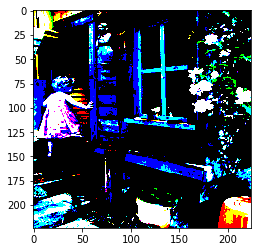

In [34]:
img = preprocess_img("CAPTION_DATA/Images/1000268201_693b08cb0e.jpg")
plt.imshow(img[0])

In [35]:
def encode_images(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector=feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [36]:
IMG_PATH="CAPTION_DATA/Images/"

In [ ]:
encoding_train = {}

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_train[img_id] = encode_images(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time stem %d"%ix)
end_t=time()
print("Total Time Taken :",end_t-start)

In [ ]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+img_id+".jpg"
    encoding_test[img_id] = encode_images(img_path)
    
    if ix%100==0:
        print("Encoding in progress Time stem %d"%ix)
end_t=time()
print("Total Time Taken(Test_Images) :",end_t-start)

In [ ]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [37]:
idx_to_word = {}
word_to_idx = {}
for i,word in enumerate(total_words):
    idx_to_word[i+1]=word
    word_to_idx[word]=i+1 

In [38]:
idx_to_word[1]

'in'

In [39]:
idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846
idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

In [40]:
vocab_size=len(word_to_idx)+1
print("Vocab_Size : ",vocab_size)

Vocab_Size :  1848


In [39]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))

print(max_len)    

35


In [44]:
with open("./Desktop/image_captioning_project/Storage/word_to_idx.pkl","wb") as w2i:
    pickle.dump(word_to_idx,w2i)

In [45]:
with open("./Desktop/image_captioning_project/Storage/idx_to_word.pkl","wb") as i2w:
    pickle.dump(idx_to_word,i2w)

In [40]:
file = open('encoded_train_features.pkl','rb')
encoding_train = pickle.load(file)
file.close()

In [41]:
encoding_train['2513260012_03d33305cf']

array([0.4002862 , 0.16570574, 0.330016  , ..., 0.67777884, 0.08826529,
       0.11751769], dtype=float32)

In [42]:
file = open('encoded_test_features.pkl','rb')
encoding_test = pickle.load(file)
file.close()

# Data Generator

In [43]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                
                    xi = pad_sequences([xi],maxlen=max_len,value = 0, padding  = 'post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y=[],[],[]
                    n = 0     

In [44]:
f = open("CAPTION_DATA/glove.6B.50d.txt", encoding = 'utf8')

In [45]:
embedding_index = {}
for line in f:
    values=line.split()
    #print(values)
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding 
    

In [46]:
f.close()

In [47]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [48]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    
    return matrix

In [49]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape #A matrix is maintained of row = vocab_size and column = glove embedding vectors....

(1848, 50)

# Model Architecture

In [50]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation = 'relu')(inp_img1)

In [53]:
#Captions As Inputs
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size, output_dim = 50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [54]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
# Combined Model..
model = Model(inputs = [input_img_features,input_captions], outputs = outputs)

In [55]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [56]:
#Important Step..
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [57]:
model.compile(loss='categorical_crossentropy', optimizer = "adam")

# Training of Model

In [61]:
epochs = 8
batch_size = 3
steps = len(train_descriptions)//6
print(steps)

1000


In [65]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model_updated.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model_updated.save('./New_weights_updated/model_'+ str(i) + '.h5')

In [404]:
train()

Epoch 1/1
2000/2000 [==============================] - 990s 495ms/step - loss: 4.2815
Epoch 1/1
2000/2000 [==============================] - 986s 493ms/step - loss: 3.5715
Epoch 1/1
2000/2000 [==============================] - 985s 493ms/step - loss: 3.3189
Epoch 1/1
2000/2000 [==============================] - 988s 494ms/step - loss: 3.1617
Epoch 1/1
2000/2000 [==============================] - 995s 497ms/step - loss: 3.0443
Epoch 1/1
2000/2000 [==============================] - 993s 497ms/step - loss: 2.9609
Epoch 1/1
2000/2000 [==============================] - 993s 497ms/step - loss: 2.8891
Epoch 1/1
2000/2000 [==============================] - 1001s 500ms/step - loss: 2.8361
Epoch 1/1
2000/2000 [==============================] - 1181s 590ms/step - loss: 2.7889
Epoch 1/1
2000/2000 [==============================] - 1144s 572ms/step - loss: 2.7488
Epoch 1/1
2000/2000 [==============================] - 1311s 656ms/step - loss: 2.7148
Epoch 1/1
2000/2000 [=============================

In [64]:
model_updated = load_model('./New_weights/model_19.h5')

In [66]:
# Model trained further with 6 images per batch and for 8 epochs.. 
train()

Epoch 1/1
1000/1000 [==============================] - 442s 442ms/step - loss: 2.5193
Epoch 1/1
1000/1000 [==============================] - 419s 419ms/step - loss: 2.4484
Epoch 1/1
1000/1000 [==============================] - 426s 426ms/step - loss: 2.3918
Epoch 1/1
1000/1000 [==============================] - 406s 406ms/step - loss: 2.3464
Epoch 1/1
1000/1000 [==============================] - 428s 428ms/step - loss: 2.3093
Epoch 1/1
1000/1000 [==============================] - 413s 413ms/step - loss: 2.2762
Epoch 1/1
1000/1000 [==============================] - 411s 411ms/step - loss: 2.2481
Epoch 1/1
1000/1000 [==============================] - 412s 412ms/step - loss: 2.2207


In [51]:
model_new = load_model('./New_weights_updated/model_7.h5')

In [52]:
def predict_caption(photo):
    
    input_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in input_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding = 'post')
        
        ypred = model_new.predict([photo,sequence])
        ypred = ypred.argmax() #Taking word with maximum probability
        word = idx_to_word[ypred]
        input_text += (' '+ word)
        
        if word == 'endseq':
            break
            
    final_caption = input_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [53]:
# Picking Some Random Images for Testing...

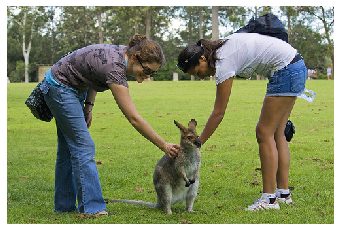

woman in white and white is running with her dog in pink jacket


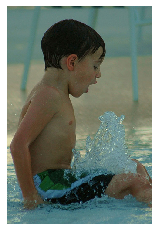

boy in swimming suit is splashing in the water


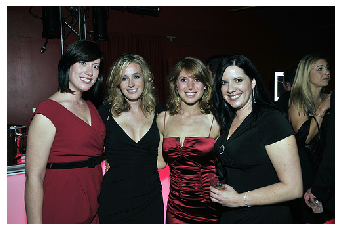

two girls in black clothes perform hold


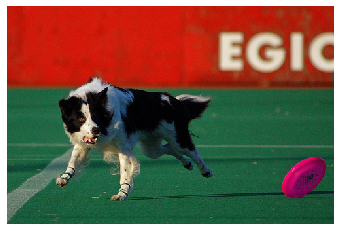

black and white dog running on lawn


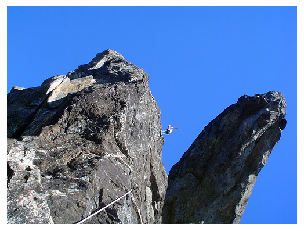

person is rock climbing


In [56]:
for i in range(5):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i=plt.imread("CAPTION_DATA/Images/"+img_name+".jpg")
    
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    
    caption = predict_caption(photo_2048)
    print(caption)